# SDSS Galaxy and Quasar Color Data
## Example of Unsupervised Learning

 >__Created__: May 2020, Harrison B. Prosper <br>
 > __Updated__: Jan 2023 HBP<br>
 > __Updated__: Mar 2023 CLASHEP 2023 HBP<br>
  > __Updated__: July 4, 2023 for Terascale 2023, DESY, Hamburg, Germany

 

### Introduction

The [Sloan Digital Sky Survey](https://sloan.org/programs/research/sloan-digital-sky-survey) (SDSS) exemplifies the longstanding tradition of researchers in astronomy, astrophysics, and cosmology of making data public. The SDSS provides a wealth of astrophysical and astronomical data that have been used for research-level work as well as for educational purposes. The collaborations at the Large Hadron Collider at CERN also release their data, albeit with a longer latency than is typical in astronomy. 

#### SDSS Color Data
Astronomers have known for decades that a plot of the color indices $g - r$ versus $u - g$ shows a striking clustering of the color data from galaxies and quasars, which makes it possible to classify these objects with these data. The color indices are measures of the fluxes through 5 SDSS filters:

| __Filter__        | __Wavelength (nm)__   |
| :---              | :--   |
| Ultraviolet (u)   | 354.3 |
| Green (g)         | 477.0 |
| Red (r)           | 623.1 |
| Near Infrared (i) | 762.5 |
| Infrared (z)      | 913.4 |

In this notebook we use a simple __autoencoder__ to find automatically clusters in the SDSS color data that are associated with galaxies and quasars.  Given two spaces $x \in \mathbb{R}^n$ and $z \in \mathbb{R}^m$, where $m \ll n$, an autoencoder models the mappings $h: x \rightarrow z$ followed by $g: z \rightarrow x$. The first mapping is called the __encoder__ and the second mapping is called the __decoder__. The low-dimensional space $\mathbb{R}^m$ is called the __latent space__. 

There is no reason, *a priori*, why an autoencoder should cluster data in the latent space; an autoencoder simply creates a compressed representation of the original data. However, if clusters exist in the original space $\mathbb{R}^n$ one would expect these clusters to be mapped to clusters in the latent space provided that in approximating the identity mapping $h: x \rightarrow z$ and $g: z \rightarrow x$  sufficient information is retained in the compressed data in the latent space. The autoencoder created in this notebook shows that the SDSS 5D color data can be mapped to the unit interval, automatically, where the galaxy and quasar clusters are clearly visible. Since the SDSS color data are already classified, we can use the SDSS __class__ labels to check to what extent the autoencoder agrees with the SDSS classification.

The data used in this example have been extracted from the SDSS website

https://cas.sdss.org/dr18/SearchTools/sql

using the following SQL query (see https://www.astroml.org/)

```sql
SELECT TOP 110000
  p.u, p.g, p.r, p.i, p.z, s.z, s.zerr, s.class
FROM PhotoObj AS p
  JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE 
      p.u BETWEEN 0 AND 20
  AND p.g BETWEEN 0 AND 20
  AND p.r BETWEEN 0 AND 20
  AND p.i BETWEEN 0 AND 20
  AND p.z BETWEEN 0 AND 20
  AND s.class <> 'UNKNOWN'
  AND s.class <> 'STAR'
  AND s.class <> 'SKY'
  AND s.class <> 'STAR_LATE'
``` 

We use 100000 data instances for training, 5000 for validation during training, and 5000 for testing post training.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# module to manipulate images and produce animated gifs
import imageio.v2 as im
    
# for importing and reloading modules
import importlib

# widely used machine learning toolkit developed by FaceBook aka Meta
import torch
import torch.nn as nn

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

We shall use the __to(device)__ method to move data and computation to the device specified in "device".
If your system includes a cuda-based GPU, the __to__ method will move data and computation to that device.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(device):4s}')

Available device: cpu 


### Load SDSS Data
  * photometric data $(u, g, r, i, z)$
  * and redshift data
  * classication of data into galaxies and quasars
  
  1. Read data are read from a CSV file into a pandas dataframe.
  1. Shuffle all  the rows (frac=1)  of the dataframe.
  1. Scale the color data so that they are of order unity.
  1. Define sequences of booleans, based on the __class__ field, to select galaxies and quasars.
  
  
The CSV file created by the SDSS SQL interface includes the comment "#Table1" in the first row. We need to skip that row using the __comment='#'__ keyword in __read\_csv__.  

In [4]:
def loadData(filename, scale=1):
    
    if not os.path.exists(filename):
        raise FileNotFound(filename)
        
    # skip commented lines
    data = pd.read_csv(filename, comment='#')
    
    # shuffle dataframe rows
    data = pd.DataFrame(data).sample(frac=1)
    
    data.u /= scale
    data.g /= scale
    data.r /= scale
    data.i /= scale
    data.z /= scale

    objclass = data['class']
    galaxies = objclass == 'GALAXY'
    quasars  = objclass == 'QSO'     
    return (data, galaxies, quasars)

In [5]:
filename = '../data/SDSS_galaxy_colors.csv.gz'
data, galaxies, quasars = loadData(filename)
print(f'number of rows: {len(data):d}')
data[:5]

number of rows: 110000


,u,g,r,i,z,z1,zerr,class
57789,17.73004,16.13879,15.41173,15.08546,14.83506,0.035332,0.000029,GALAXY
96484,19.05846,18.86411,18.63060,18.49771,18.50473,1.364920,0.000404,QSO
74923,19.80838,18.23103,17.46971,17.07028,16.81136,0.113291,0.000026,GALAXY
98625,19.82836,17.94508,16.77035,16.29490,15.94862,0.163269,0.000027,GALAXY
52656,18.82469,17.09941,16.17393,15.73379,15.44834,0.126201,0.000029,GALAXY


### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of the fitted model.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.


In [6]:
def splitData(dd, gg, qq, start, end):
    d = dd[start:end]
    g = gg[start:end]
    q = qq[start:end]
    return d, g, q

start = 0
end   = 100000
train_data, train_galaxies, train_quasars = splitData(data, 
                                                       galaxies, 
                                                       quasars,
                                                       start, end)
start = end
end  += 5000
valid_data, valid_galaxies, valid_quasars = splitData(data, 
                                                       galaxies, 
                                                       quasars,
                                                       start, end)

start = end
end  += 5000
test_data, test_galaxies, test_quasars  = splitData(data, 
                                                    galaxies, 
                                                    quasars,
                                                    start, end)

print(len(train_data), len(valid_data), len(test_data))
train_data[:5]

100000 5000 5000


,u,g,r,i,z,z1,zerr,class
57789,17.73004,16.13879,15.41173,15.08546,14.83506,0.035332,0.000029,GALAXY
96484,19.05846,18.86411,18.63060,18.49771,18.50473,1.364920,0.000404,QSO
74923,19.80838,18.23103,17.46971,17.07028,16.81136,0.113291,0.000026,GALAXY
98625,19.82836,17.94508,16.77035,16.29490,15.94862,0.163269,0.000027,GALAXY
52656,18.82469,17.09941,16.17393,15.73379,15.44834,0.126201,0.000029,GALAXY


### Plot $g - r$ versus $u - g$

In [7]:
def plotColors(data, g, q, 
               xmin=-0.5, xmax=2.5, 
               ymin=-0.5, ymax=1.5,
               ftsize=14):
    
    x = data['u'] - data['g']
    y = data['g'] - data['r']
    
    # set size of figure
    plt.figure(figsize=(5, 3.5))
    
    # annotate axes
    plt.xlabel('$u - g$', fontsize=ftsize)
    plt.ylabel('$g - r$', fontsize=ftsize)
    
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    
    plt.scatter(x[q], y[q], 
                c='red', 
                s=5, marker='.', 
                label='quasars')
    
    plt.scatter(x[g], y[g], 
                c='blue', 
                s=5, marker='.',
                label='galaxies')

    plt.legend()

    plt.savefig('astro_color.png')
    plt.show()

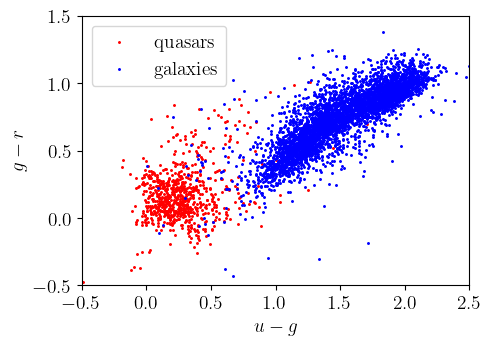

In [8]:
plotColors(test_data, test_galaxies, test_quasars)

### Convert data to pytorch tensors and send to computational device

In [9]:
def dataFrame2Tensor(df, source):
    # change from pandas dataframe to PyTorch tensors
    # and load data to device.
    x = torch.tensor(df[source].to_numpy()).float().to(device)
    return (x, x)

In [10]:
features = ['u', 'g', 'r', 'i', 'z']
train_x, train_t = dataFrame2Tensor(train_data, features)
valid_x, valid_t = dataFrame2Tensor(valid_data, features)
test_x,  test_t  = dataFrame2Tensor(test_data,  features)

### Define empirical risk function
An autoencoder models the identity mapping $f: x \rightarrow x$ in two stages: $h: x \rightarrow z$ (the encoder stage) followed by $g: z \rightarrow x$ (the decoder stage), where $x \in \mathbb{R}^n$ and $z \in \mathbb{R}^m$ with $m \ll n$. In this example, $n = 5$ and $m = 1$ with $z$ restricted to the unit interval.

We fit an autoencoder by minimizing the average quadratic loss,
\begin{align*}
  F & = \frac{1}{N} \sum_{i=1}^N (t_i -  f(x_i, \omega))^2,
\end{align*}
where the targets $t_i = x_i$.

In principle, we want $N$ to be as large as possible to approximate the average loss in the limit $N \rightarrow \infty$. In practice, $n = batch\_size \ll N$, the training sample size. This is done to produce a noisy approximation of the local
gradient. The stochasticity thereby introduced increases the probability that the minimizer won't get stuck in a local minimum that is a poor approximation to the global minimum of the average loss in the limit $N \rightarrow \infty$.

In [11]:
# Note: there are several average loss functions available 
# in PyTorch, such as nn.CrossEntropyLoss(), but it's useful 
# to know how to create your own.
def averageQuadraticLoss(f, t):
    # f and t must be of the same shape
    losses = (f - t)**2
    return torch.mean(losses)

def getRandomBatch(x, t, batch_size, n=None):
    indices = np.random.choice(len(x), batch_size)
    return x[indices], t[indices]

def validate(model, avloss, x, t):
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        # reshape to ensure that y and t are of the same shape!
        y = model(x).reshape(t.shape)
    return avloss(y, t)

def numberOfParameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Create animated GIF of 1D latent space

In [12]:
def plotLatentSpace(bag, 
                    xbins=100, xmin=0.0, xmax=1.0, 
                    ymin=0.0, ymax=500.0,
                    ftsize=14, fps=5):
        
    fig, ax = plt.subplots(figsize=(5, 4))
    fig.tight_layout()
    
    ax.set_xlabel('$x$', fontsize=ftsize)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    # ii: iteration number
    # x : latent space coordinates (in this example, x lies in [0,1])
    # s : object selectors (objects classified as galaxies and quasars)
    # l : labels (for the two classes)
    # c : colors (for the two classes)
    ii     = bag.ii   
    x      = bag.latent
    s1, s2 = bag.select 
    l1, l2 = bag.labels
    c1, c2 = bag.colors
    
    if bag.makegif:
        if bag.ii == 0:
            bag.writer = im.get_writer('autoencoder_anim.gif', mode='I', fps=fps)
    
    # histogram latent space points for class 1 (galaxies)
    ax.hist(x[s1], bins=xbins, range=(xmin, xmax), 
            color=c1, alpha=0.3, label=l1)
    
    # histogram latent space points for class 2 (quasars)
    ax.hist(x[s2], bins=xbins, range=(xmin, xmax),
            color=c2, alpha=0.3, label=l2)
    
    ax.legend(loc='upper left')
    
    if bag.makegif:
        ax.text(0.05, 100, f'iterations: {ii:6d}')
        
        filename = 'f%7.7d.png' % ii
        plt.savefig(filename)
        
        bag.writer.append_data(im.imread(filename))
        os.system(f'rm -f {filename:s}')
        
        plt.close()
    else:
        filename = 'autoencoder.png'
        plt.savefig(filename)
        plt.show()

### Trainer

In [13]:
def trainModel(bag, model, optimizer, averageloss, getbatch,
               train_x, train_t, valid_x, valid_t,
               val_galaxies, val_quasars,
               batch_size, number_iterations,
               losses, 
               step=10, 
               nframes=100):
    import copy
    
    # to keep track of average losses
    xx, yy_t, yy_v = losses

    N = len(valid_x)
    
    print("%10s\t%10s\t%10s" % \
              ('iteration', 'training', 'validation'))

    # start caching the best model after the
    # following number of iterations.
    start_saving = number_iterations // 100
    best_model   = None
    min_avloss   = float('inf')
    saved        = '' # iterations before a better model is cached.
    iisaved      = 0

    bag.select   = [val_galaxies[:N], val_quasars[:N]]
    
    fstep = number_iterations / nframes
    
    for ii in range(number_iterations):
        bag.ii = ii
        
        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
    
        # get a batch of data 
        x, t = getbatch(train_x, train_t, batch_size, ii)     

        # compute the output of the model for the batch of data x
        y = model(x).reshape(t.shape)
   
        # compute a noisy approximation of the average loss.
        # Adding a bit of noise helps the minimizer escape
        # minima that may not optimal. It is also much
        # faster to compute the loss function and its gradient
        # with respect to its parameters using batches of 
        # training data rather than the full training dataset.
        empirical_risk = averageloss(y, t)
        
        # use automatic differentiation to compute a 
        # the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the (noisy) local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            # validate current model on a subset of training data
            avloss_t = validate(model, averageloss, 
                                train_x[:N], train_t[:N])
            
            # validate current model on a subset of validation data.
            # we use the validation data to decide when to stop the
            # training.
            avloss_v = validate(model, averageloss, 
                                valid_x, valid_t)

            # create a frame for the animated gif using the
            # current model applied to the validation data.
            if ii % fstep == 0:
                if bag.makegif:
                    bag.latent = model.latent()
                    plotLatentSpace(bag)
            
            if ii > start_saving:
                # number of iterations that have elapsed before a
                # higher performing model has been found based on
                # the average loss computed using the validation data
                saved = str(ii - iisaved)
            
            # keep track of average losses versus iteration number
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.7f\t%10.7f %s" % \
                      (xx[-1], avloss_t, avloss_v, saved))
            else:
                xx.append(xx[-1] + step)
                print("\r%10d\t%10.7f\t%10.7f %s" % \
                      (xx[-1], avloss_t, avloss_v, saved), 
                      end='')
            
            yy_t.append(avloss_t)
            yy_v.append(avloss_v)
            
            if avloss_v < min_avloss:
                min_avloss = avloss_v
                
                if ii > start_saving:
                    iisaved = ii
                    best_model = copy.deepcopy(model)

    print() 
    
    return (xx, yy_t, yy_v), best_model

In [14]:
def plotAverageLosses(losses):
    
    xx, yy_t, yy_v = losses
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 4))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    ax.plot(xx, yy_t, color='red',  lw=1, label='training loss')
    ax.plot(xx, yy_v, color='blue', lw=1, label='validation loss')
    ax.legend(loc='upper right')
    
    ax.set_xlabel('iterations', fontsize=14)
    ax.set_ylabel('average loss', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    
    filename = 'autoencoder_loss.png'
    plt.savefig(filename)
    plt.show()

# Define model

Write the following cell to the file __astronn1d.py__.

In [15]:
%%writefile astronn1d.py
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    
    def __init__(self):
        """
    A fully-connected autoencoder neural network.
        """ 
        # call constructor of base (or super, or parent) class
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(5 ,  25), nn.ReLU(),
            nn.Linear(25,  25), nn.ReLU(), 
            nn.Linear(25,  25), nn.ReLU(), 
            nn.Linear(25,   1), nn.Sigmoid())
        
        self.decoder = nn.Sequential(
            nn.Linear(1,   25), nn.ReLU(),
            nn.Linear(25,  25), nn.ReLU(), 
            nn.Linear(25,  25), nn.ReLU(), 
            nn.Linear(25,  5))

    def forward(self, x):
        y = self.encoder(x)
        self.z = y # cache latent space points
        y = self.decoder(y)
        return y
    
    def latent(self):
        return self.z.data.numpy()

Writing astronn1d.py


### Create an instance of the model
Note the import of the class that we've just saved.

In [16]:
import astronn1d as ast
importlib.reload(ast)
model = ast.AutoEncoder().to(device)
print(f'number of parameters: {numberOfParameters(model):8d}')
model

number of parameters:     2956


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=1, bias=True)
    (7): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=5, bias=True)
  )
)

### Choose minimizer

In [18]:
learning_rate = 1.e-4
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

average_loss  = averageQuadraticLoss

step          = 10
losses        = ([], [], [])

class Bag:
    pass
bag = Bag()

bag.labels = ['galaxies', 'quasars']
bag.colors = ['blue', 'red']
bag.makegif= True

 iteration	  training	validation
         0	308.1055298	307.2593079 
     49990	 0.0847167	 0.0880669 33000


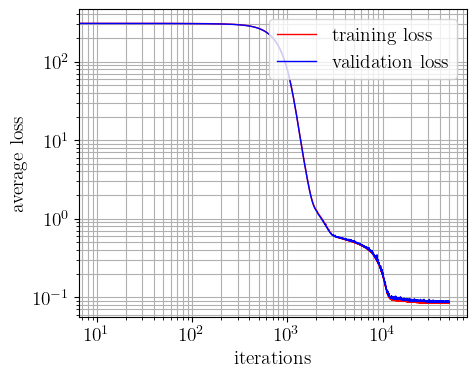

In [19]:
niterations= 50000
batch_size = 64      # sample over which to compute average loss
    
losses, best_model = trainModel(bag, 
                                 model, optimizer, average_loss, 
                                 getRandomBatch,
                                 train_x, train_t, 
                                 valid_x, valid_t,
                                 valid_galaxies, valid_quasars,
                                 batch_size, niterations,
                                 losses, step)

plotAverageLosses(losses)

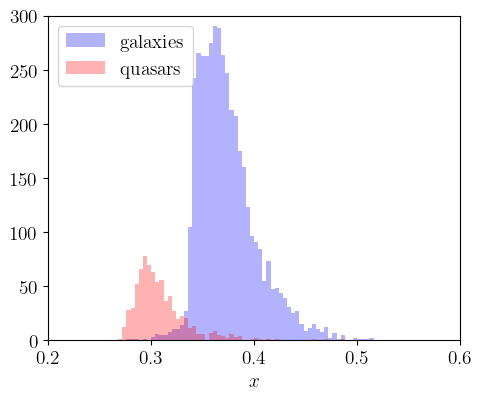

In [24]:
best_model.eval()
y = best_model(test_x)

bag.latent = best_model.latent()
bag.select = [test_galaxies, test_quasars]
bag.makegif= False

plotLatentSpace(bag, xbins=100, xmin=0.2, xmax=0.6, ymax=300)